# Machine Learning Course Project
## Identifying User Stance On Social Media via Semi-Supervised Learning

### Overview

#### Midsem Pipeline - 

 - **Read Data**: Read text files to load all the words. 
 - **Clean Data**: Remove stop-words, everything lowercase, dehashify hashtags.
 - **Format Data**: Create data in a format required by each baseline method. 
 - **Baseline Approaches**: LSA, pLSA, Para2Vec, LDA Topic Modelling. The goal of these approaches is to create a "FIXED SIZE" and "HIGH LEVEL" feature representation for variable length tweets. These representations leverage our unlabelled data. 
 - **Training**: Some Supervised Learning on the learned representation using the given labels. 
 - **Evaluation**: Compare the different methods mentioned above on different datasets. 

#### Endsem Approaches - 
 - LDA2Vec - https://www.datacamp.com/community/tutorials/lda2vec-topic-model
 - Gaussian LDA - https://rajarshd.github.io/papers/acl2015.pdf
 - Word Embeddings Informed Topic Models - http://proceedings.mlr.press/v77/zhao17a/zhao17a.pdf
 
#### Reference
 - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Constants

In [1]:
PATH_LABELLED_DATA_TRUMP = "../semeval2016-task6-domaincorpus/data-all-annotations/testdata-taskB-all-annotations.txt"
PATH_UNLABELLED_DATA_TRUMP = "./../semeval2016-task6-domaincorpus/downloaded_Donald_Trump.txt"

## Setup

In [2]:
# SETUP
# # Run in python console
# import nltk; nltk.download('stopwords')

# # Run in terminal or command prompt
# !python -m spacy download en

In [3]:
# !pip install gensim
# !pip install pyLDAvis

In [4]:
import pandas as pd
import numpy as np
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LsiModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['via'])

### Read Sem-Eval Task A Data (Labelled)

Interactive Visualization - http://www.saifmohammad.com/WebPages/StanceDataset.htm

Targets - 
 - Hilary Clinton
 - Atheism
 - Climate Change
 - Donald Trump
 - Feminism
 - Abortion

In [6]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

data_labelled_train = pd.concat([X_train, y_train], ignore_index=True, axis=1)
data_labelled_train.columns = ['Tweet', 'Stance']
data_labelled_test = pd.concat([X_test, y_test], ignore_index=True, axis=1)
data_labelled_test.columns = ['Tweet', 'Stance']

### Remove Symbols

In [7]:
def clean_tweets(sent):
    sent = str(sent)
    
    # Remove new line characters
    sent = re.sub('\s+', ' ', sent)

    # Remove distracting single quotes
    sent = re.sub("\'", "", sent)

    # Remove distracting single quotes
    sent = re.sub("\"", "", sent)

    # Remove hashtags
    sent = re.sub("\#", "", sent)

    # Remove http:// links
    sent = re.sub('http:\/\/.*','', sent)

    # Remove https:// links
    sent = re.sub('https:\/\/.*','', sent)
        
    return sent
    

#### Data Stats

In [8]:
data_labelled_train.where(data_labelled_train.Stance == 'AGAINST').count()

Tweet     211
Stance    211
dtype: int64

In [9]:
data_labelled_train.where(data_labelled_train.Stance == 'NONE').count()

Tweet     209
Stance    209
dtype: int64

In [10]:
data_labelled_train.where(data_labelled_train.Stance == 'FAVOR').count()

Tweet     207
Stance    207
dtype: int64

In [11]:
data_labelled_test.where(data_labelled_test.Stance == 'AGAINST').count()

Tweet     88
Stance    88
dtype: int64

In [12]:
data_labelled_test.where(data_labelled_test.Stance == 'NONE').count()

Tweet     90
Stance    90
dtype: int64

In [13]:
data_labelled_test.where(data_labelled_test.Stance == 'FAVOR').count()

Tweet     92
Stance    92
dtype: int64

In [14]:
combined_data = pd.concat([data_labelled_train, data_labelled_test], ignore_index=True)

In [15]:
combined_data.count()

Tweet     897
Stance    897
dtype: int64

In [16]:
combined_data.head(10)

,Tweet,Stance
0,NASCAR abandons Trump. Some good news to end m...,AGAINST
1,Ill believe it when I see it. BringBackOurUran...,NONE
2,@Reince & GOP You built that -----> SemST,NONE
3,@realDonaldTrump It takes great bravery to st...,FAVOR
4,"Really DonaldTrump, all Mexican people are rap...",AGAINST
5,"@boxxers06 This may be true. However, many Ame...",NONE
6,@realDonaldTrump needs to learn when to stop t...,AGAINST
7,"If you live in a Trump building, congratulatio...",FAVOR
8,"......and some, I assume, are good people. SemST",AGAINST
9,@realDonaldTrump youre the man for the job Mak...,FAVOR


In [17]:
df = combined_data['Tweet']

In [18]:
data = df.values.tolist()
pprint(data[:1])

['NASCAR abandons Trump. Some good news to end my day with Trump SemST']


### Sentences To Words

In [19]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['nascar',
  'abandons',
  'trump',
  'some',
  'good',
  'news',
  'to',
  'end',
  'my',
  'day',
  'with',
  'trump',
  'semst']]


### Create Bi-Grams Tri-Grams

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['nascar', 'abandons', 'trump', 'some', 'good', 'news', 'to', 'end', 'my', 'day', 'with', 'trump', 'semst']


### Remove Stop Words and Lemmatize

WE NEED PRONOUNS FOR STANCE

In [21]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PRON']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [22]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PRON'])

print(data_lemmatized[:1]), print(len(data_lemmatized))

[['nascar', 'abandon', 'trump', 'good', 'news', 'end', 'day', 'trump', 'semst']]
897


(None, None)

## Format Data

In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2)]]


In [24]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abandon', 1),
  ('day', 1),
  ('end', 1),
  ('good', 1),
  ('nascar', 1),
  ('news', 1),
  ('semst', 1),
  ('trump', 2)]]

In [25]:
len(id2word)

1900

## Mallet-LDA

### Model Search

In [26]:
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet('./mallet-2.0.8/bin/mallet', corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
train_corpus = corpus[:627]
train_data_lemmatized = data_lemmatized[:627]
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=train_corpus, texts=train_data_lemmatized, start=2, limit=51, step=6)

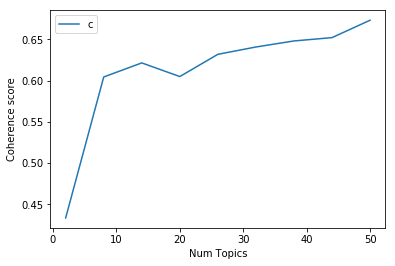

In [29]:
limit=51; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
len(corpus)

897

In [31]:
num_topics = x[np.argmax(coherence_values)]

In [32]:
num_topics

50

In [33]:
mallet_path = './mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=train_corpus, num_topics=num_topics, id2word=id2word)
ldamallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [34]:
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("lda-mallet-model-only-labelled-without-unlabelled-"+str(num_topics)+"dont-include-test")
ldamallet.save(temp_file)

In [35]:
from gensim.test.utils import datapath

temp_file = datapath("lda-mallet-model-only-labelled-without-unlabelled-"+str(num_topics)+"dont-include-test")
# Load a potentially pretrained model from disk.
ldamallet = gensim.models.ldamodel.LdaModel.load(temp_file)

In [36]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(26,
  [('trump', 0.22857142857142856),
   ('candidate', 0.19047619047619047),
   ('card', 0.05714285714285714),
   ('semst', 0.02857142857142857),
   ('prediction', 0.02857142857142857),
   ('decide', 0.02857142857142857),
   ('bring', 0.02857142857142857),
   ('defend', 0.02857142857142857),
   ('anymore', 0.01904761904761905),
   ('shape', 0.01904761904761905)]),
 (16,
  [('realdonaldtrump', 0.24793388429752067),
   ('watch', 0.06611570247933884),
   ('general', 0.06611570247933884),
   ('defense', 0.049586776859504134),
   ('run', 0.04132231404958678),
   ('recommend_seanhannity', 0.04132231404958678),
   ('new_atty', 0.04132231404958678),
   ('sec', 0.03305785123966942),
   ('semst', 0.03305785123966942),
   ('marcorubio', 0.03305785123966942)]),
 (38,
  [('gop', 0.12598425196850394),
   ('loser', 0.07874015748031496),
   ('plan', 0.06299212598425197),
   ('reince', 0.047244094488188976),
   ('jeb', 0.047244094488188976),
   ('put', 0.03937007874015748),
   ('romney', 0.039370078

### Topic Quality Inspection

In [37]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.6650534519265766


## Evaluation

### Create Dataset for Supervised Learning

In [38]:
mallet_feats = []

for i in range(len(corpus)):
    representation = ldamallet.get_document_topics(corpus[i])
    count = 0
    feat = []
    for i in range(num_topics):
        if i in list(map((lambda x: x[0]), representation)):
            feat.append(representation[count][1])
            count = count + 1
        else:
            feat.append(0)
    mallet_feats.append(feat)

In [39]:
STANCES = ['AGAINST', 'FAVOR', 'NONE']

In [40]:
def transform_labels(label):
    if label == 'AGAINST':
        return 0
    elif label == 'FAVOR':
        return 1
    elif label == 'NONE':
        return 2

In [41]:
labelled_stance = combined_data.Stance
labelled_stance = labelled_stance.apply(transform_labels)
labelled_stance = labelled_stance.tolist()

In [42]:
len(mallet_feats[0]), len(mallet_feats), len(labelled_stance)

(50, 897, 897)

## Supervised Learning

In [43]:
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import argparse
from sklearn.utils.multiclass import unique_labels

In [44]:
## Create Train Test Split
X_train = mallet_feats[:627]
X_test = mallet_feats[627:]
y_train = labelled_stance[:627]
y_test = labelled_stance[627:]

In [45]:
len(y_test)

270

In [46]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [47]:
def RandomForest(X_train, X_test, y_train, y_test):
    
    # GRID SEARCH
    parameters = {'n_estimators':range(100,600,100), 'max_depth':range(1,20,5)}
    rlf = RandomForestClassifier(random_state=0)
    rlf = GridSearchCV(rlf, parameters, cv=5)
    rlf.fit(X_train, y_train)
    
    y_pred = rlf.predict(X_test)

    rf_cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, classes=STANCES,
                      title='Confusion matrix, without normalization')

    rf_cv = cross_val_score(rlf, X_train, y_train, cv=5, scoring='f1_macro')
    report = {}
    report["RF_cross_val_score"] = rf_cv.tolist()
    report["RF_mean_acc"] = rf_cv.mean()
    report["RF_std_acc"] = rf_cv.std()*2
    report["RF_best_estimator"] = rlf.best_estimator_
    
    report["RF_CM"] = rf_cm.tolist()
    
    f1_macro = f1_score(y_test, y_pred, average='macro') 
    report["RF_F1_SCORE"] = f1_macro

    
    return report

In [48]:
def SVMClassifier(X_train, X_test, y_train, y_test):

    parameters = {'kernel':['linear','rbf','poly'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    
    clf = svm.SVC(gamma='auto')
    clf = GridSearchCV(clf, parameters, cv=5)
    clf.fit(X_train, y_train)
    
    clf_cv = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')
    report = {}
    report["SVM_cross_val_score"] = clf_cv.tolist()
    report["SVM_mean_acc"] = clf_cv.mean()
    report["SVM_std_acc"] = clf_cv.std()*2
    report["SVM_best_estimator"] = clf.best_estimator_

    
    y_pred = clf.predict(X_test)

    clf_cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, classes=STANCES,
                      title='Confusion matrix, without normalization')

    report["SVM_CM"] = clf_cm.tolist()
    
    f1_macro = f1_score(y_test, y_pred, average='macro') 
    report["SVM_F1_SCORE"] = f1_macro

    
    return report
    

In [ ]:
mallet_report = RandomForest(X_train, X_test, y_train, y_test)
print(mallet_report)

Confusion matrix, without normalization
[[58 12 18]
 [ 4 88  0]
 [ 4  2 84]]


In [ ]:
mallet_report = SVMClassifier(X_train, X_test, y_train, y_test)
print(mallet_report)